# Test log-ratios derived from differential abundance/expression tools on the test dataset

In [29]:
import math
import random
import sklearn
import pandas as pd
import matplotlib
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from qiime2 import Artifact

In [30]:
# Get the LaTeX math mode stuff working as expected: https://stackoverflow.com/a/23856968
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

## Load relevant data for all differential abundance outputs

In [31]:
metadata = pd.read_csv("../data/final_metadata.tsv", sep="\t", index_col=0)

In [32]:
cancer_metadata = metadata.loc[metadata["Status"] != "N"]

In [33]:
testcm = cancer_metadata.loc[cancer_metadata["TrainTest"] == "Test"]
traincm = cancer_metadata.loc[cancer_metadata["TrainTest"] == "Train"]
print(f"{testcm.shape[0]} test cancer samples.")
print(f"{traincm.shape[0]} train cancer samples.")
testcm

29 test cancer samples.
67 train cancer samples.


,Age,Gender,Status,TotalNumReads,NumUniquelyMappedReads,UniquelyMappedReadsPercentage,CancerSubtype,ChemotherapyStatus,GnRHTherapyStatus,TAMTherapyStatus,AITherapyStatus,BSOTherapyStatus,TrainTest
SampleID,,,,,,,,,,,,,
C2,43.35,Female,C-R,"7,870,895","6,526,361",82.92%,TripleNegative,A,NaN,NaN,NaN,NaN,Test
C4,41.42,Female,C-R,"8,248,171","7,041,599",85.37%,TripleNegative,A,NaN,NaN,NaN,NaN,Test
C5,42.12,Female,C-R,"9,233,397","7,922,603",85.80%,LuminalA/Normal-like,D,B,B,NaN,NaN,Test
C6,36.52,Female,C-R,"7,156,841","6,140,656",85.80%,LuminalA/Normal-like,A,B,NaN,NaN,NaN,Test
C8,37.35,Female,C-R,"8,374,268","7,298,256",87.15%,LuminalA/Normal-like,A,NaN,B,NaN,NaN,Test
C11,44.98,Female,C-R,"6,848,186","5,824,106",85.05%,LuminalA/Normal-like,A,NaN,NaN,NaN,NaN,Test
C12,34.71,Female,C-R,"7,093,422","5,976,848",84.26%,TripleNegative,D,NaN,NaN,NaN,NaN,Test
C15,36.61,Female,C-R,"7,620,354","6,510,882",85.44%,TripleNegative,A,NaN,NaN,NaN,NaN,Test
C26,38.41,Female,C-R,"7,799,765","6,661,309",85.40%,HER2Enriched,A,A,NaN,NaN,NaN,Test


In [34]:
# Load the table as a DataFrame, not a biom.Table, since I can't figure out a good way to add pseudocounts
# in biom.Table (transform() doesn't operate on zero values ._.)
tbl = pd.read_csv("output/cancer_table_with_header.tsv", sep="\t", index_col=0)
tbl

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96
FeatureID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,7.071605,60.610797,58.255903,29.917356,24.500322,25.311091,37.394452,15.354658,24.839014,24.591295,...,14.134044,10.803910,6.068982,12.714350,15.983392,0.000000,38.189128,15.608352,51.519267,30.805593
ENSG00000000005,13.279391,47.424080,60.455497,6.482332,53.675826,31.686900,32.409716,0.000000,48.976056,46.178684,...,0.000000,12.172853,136.759411,28.650721,0.000000,0.000000,5.976111,6.280734,241.863225,0.000000
ENSG00000000419,0.000000,0.000000,23.040206,8.646690,20.456404,42.266702,21.615428,11.538256,18.665274,76.996356,...,79.657691,8.118597,0.000000,0.000000,0.000000,179.178412,15.942897,0.000000,0.000000,0.000000
ENSG00000000457,6.212355,2.218590,12.120963,6.065120,16.142519,37.059356,7.580945,0.000000,0.000000,21.603278,...,18.624986,15.660412,33.988677,0.000000,36.858404,83.788404,18.172309,2.938248,14.547636,10.148436
ENSG00000000460,34.038592,35.828348,55.926653,10.494273,14.482668,19.236768,13.117055,4.667898,18.877984,12.459809,...,17.903438,19.706680,23.062537,1.932615,28.344382,3.020339,27.411791,1.694651,3.729079,7.804221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000283117,6.856902,9.795095,13.378542,13.388781,19.797049,8.180871,8.367486,0.000000,18.063651,11.922335,...,34.262288,0.000000,8.827079,0.000000,61.992460,0.000000,6.171609,45.403383,0.000000,56.006801
ENSG00000283118,16.599238,0.000000,0.000000,0.000000,57.509813,19.804313,0.000000,0.000000,0.000000,28.861678,...,16.588481,0.000000,64.105974,0.000000,0.000000,0.000000,44.820832,0.000000,259.139170,0.000000
ENSG00000283122,22.357146,4.562460,12.463189,6.236364,3.688509,22.863419,7.794987,33.287541,26.924393,0.000000,...,35.109888,2.927740,8.223135,0.000000,0.000000,32.307790,14.373377,12.084831,46.537173,0.000000


## Pseudocounts: add 1 to all values in the matrix

Not ideal, but a simple way of preventing sample dropout. Plus this makes sure that our data is consistent with the data available to CoDaCoRe, for replicating the ratios created there.

In [35]:
tbl_pc = tbl.add(1)
assert (tbl_pc != 0).all().all()
tbl_pc

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96
FeatureID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,8.071605,61.610797,59.255903,30.917356,25.500322,26.311091,38.394452,16.354658,25.839014,25.591295,...,15.134044,11.803910,7.068982,13.714350,16.983392,1.000000,39.189128,16.608352,52.519267,31.805593
ENSG00000000005,14.279391,48.424080,61.455497,7.482332,54.675826,32.686900,33.409716,1.000000,49.976056,47.178684,...,1.000000,13.172853,137.759411,29.650721,1.000000,1.000000,6.976111,7.280734,242.863225,1.000000
ENSG00000000419,1.000000,1.000000,24.040206,9.646690,21.456404,43.266702,22.615428,12.538256,19.665274,77.996356,...,80.657691,9.118597,1.000000,1.000000,1.000000,180.178412,16.942897,1.000000,1.000000,1.000000
ENSG00000000457,7.212355,3.218590,13.120963,7.065120,17.142519,38.059356,8.580945,1.000000,1.000000,22.603278,...,19.624986,16.660412,34.988677,1.000000,37.858404,84.788404,19.172309,3.938248,15.547636,11.148436
ENSG00000000460,35.038592,36.828348,56.926653,11.494273,15.482668,20.236768,14.117055,5.667898,19.877984,13.459809,...,18.903438,20.706680,24.062537,2.932615,29.344382,4.020339,28.411791,2.694651,4.729079,8.804221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000283117,7.856902,10.795095,14.378542,14.388781,20.797049,9.180871,9.367486,1.000000,19.063651,12.922335,...,35.262288,1.000000,9.827079,1.000000,62.992460,1.000000,7.171609,46.403383,1.000000,57.006801
ENSG00000283118,17.599238,1.000000,1.000000,1.000000,58.509813,20.804313,1.000000,1.000000,1.000000,29.861678,...,17.588481,1.000000,65.105974,1.000000,1.000000,1.000000,45.820832,1.000000,260.139170,1.000000
ENSG00000283122,23.357146,5.562460,13.463189,7.236364,4.688509,23.863419,8.794987,34.287541,27.924393,1.000000,...,36.109888,3.927740,9.223135,1.000000,1.000000,33.307790,15.373377,13.084831,47.537173,1.000000


## Utility function: Show a fancy box- /jitter- plot of recurrent vs. nonrecurrent samples for some samples and a log-ratio

Takes as input a DataFrame of sample metadata, the selected numerator and denominator features in a log-ratio, and some other parameters.

In [47]:
def lr_boxjitterplot(sampledf, num_features, den_features, title, ax, compute_balances=False, sampleid2color=None):

    # These are now "vectors" of sample IDs by either the sums or geometric means of the selected features
    def filter_and_agg_tbl(t, features, samples):
        featurefiltered_tbl = t.loc[features]
        samplefiltered_tbl = featurefiltered_tbl[samples]
        if compute_balances:
            # geometric mean - this could probs be done in a more efficient way
            return samplefiltered_tbl.product() ** (1 / len(features))
        else:
            return samplefiltered_tbl.sum()

    num_agg = filter_and_agg_tbl(tbl_pc, num_features, sampledf.index)
    den_agg = filter_and_agg_tbl(tbl_pc, den_features, sampledf.index)

    sampleid2logratio = {}
    cr_logratios = []
    cn_logratios = []
    excluded_samples = []
    
    for samp in sampledf.index:
        ns = num_agg.loc[samp]
        ds = den_agg.loc[samp]
        
        if ns > 0 and ds > 0:
            logratio = math.log(ns / ds, math.e)
            sampleid2logratio[samp] = logratio
        else:
            raise ValueError("We should've removed zeroes already using pseudocounts...?")
#             sampleid2logratio[samp] = None
#             excluded_samples.append(samp)
#             continue
        samp_status = sampledf["Status"][samp]
        if samp_status == "C-R":
            cr_logratios.append(logratio)
        elif samp_status == "C-N":
            cn_logratios.append(logratio)
        else:
            raise ValueError("excuse me")

    # Draw a horizontal grid, but behind the bars: to do this we use distinct zorders.
    # From https://stackoverflow.com/a/23358722.
    ax.grid(axis="y", zorder=0)

    # Draw a nice boxplot...
    ax.boxplot([cn_logratios, cr_logratios], labels=["C-N", "C-R"], zorder=100, sym="",
               medianprops={"color": "#000000", "linewidth": 3}, boxprops={"linewidth": 3},
               whiskerprops={"linewidth": 2}, capprops={"linewidth": 2})

    # ... and also draw the actual points behind the scatterplot at low transparency.
    # This approach is based on https://stackoverflow.com/a/29780292, which was in turn based on
    # https://nbviewer.jupyter.org/gist/fonnesbeck/5850463.
    jitter = 0.12
    get_jitter = lambda x: ((random.random() * jitter * random.choice([1, -1]))) + x
    for si, samp in enumerate(sampledf.index):
        if sampleid2logratio[samp] is not None:
            samp_status = sampledf["Status"][samp]

            # matplotlib uses x values of 1 for C-N (the first boxplot category)
            # and 2 for C-R. No idea why these are 1-indexed instead of 0-indexed (using x=0 didn't
            # seem to show any points...?), but I'm not gonna question it.
            if samp_status == "C-N":
                x = get_jitter(1)
            else:
                x = get_jitter(2)

            if sampleid2color is None:
                sc = "#007799" if samp_status == "C-N" else "#cc3300"
            else:
                sc = sampleid2color[samp]

            ax.scatter(x, sampleid2logratio[samp], alpha=0.5, color=sc, zorder=5)

    # To make the plot look prettier (?) hide the top and right lines. From https://stackoverflow.com/a/28720127.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_title(title, fontsize=16)
    ax.set_ylabel("Log-Ratio", fontsize=15)
    ax.set_xlabel("Recurrence Status", fontsize=15)

    ax.tick_params(labelsize=16)
    
    if len(excluded_samples) > 0:
        print("Samples excluded:", excluded_samples)
    
    return sampleid2logratio

## Utility function: apply logistic regression to the training data, then see how well the log-ratio generalizes to the test data

In [37]:
def logistic_regression_on_logratios(trsamp2lr, tesamp2lr):
    
    # 0 for C-N (nonrecurrent), 1 for C-R (recurrent)
    training_truth_classes = []
    input_training_data = []
    training_sample_order = list(trsamp2lr.keys())
    for samp in training_sample_order:
        if traincm["Status"][samp] == "C-N":
            training_truth_classes.append(0)
        else:
            training_truth_classes.append(1)
        # Needs to be a 2-D array
        input_training_data.append([trsamp2lr[samp]])
            
    lrm = LogisticRegression(random_state=333).fit(input_training_data, training_truth_classes)
        
    test_truth_classes = []
    input_test_data = []
    test_sample_order = list(tesamp2lr.keys())
    for samp in test_sample_order:
        if testcm["Status"][samp] == "C-N":
            test_truth_classes.append(0)
        else:
            test_truth_classes.append(1)
        input_test_data.append([tesamp2lr[samp]])
    
    predictions = lrm.predict(input_test_data)
    
    print("Test ground truths:", test_truth_classes)
    print("Test predictions:  ", list(predictions))
    
    # We are a bit lazy here, and rather than directly mapping samples to false positive, false negative,
    # true positive, true negative we just map them to the color of their classification. this should make
    # visually highlighting misclassifications obvious on a plot.
    testsamp2color = {}
    
    tp = fp = tn = fn = 0
    for si, samp in enumerate(test_sample_order):
        real_val = test_truth_classes[si]
        pred_val = predictions[si]
        if real_val == 0:
            if pred_val == 0:
                tn += 1
                testsamp2color[samp] = "#007799"
            else:
                fp += 1
                testsamp2color[samp] = "#cc3300"
        else:
            if pred_val == 0:
                fn += 1
                testsamp2color[samp] = "#007799"
            else:
                tp += 1
                testsamp2color[samp] = "#cc3300"
                
    print(f"True positives: {tp}")
    print(f"False positives: {fp}")
    print(f"True negatives: {tn}")
    print(f"False negatives: {fn}")
    
    acc = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"Accuracy: {100*acc:.2f}%")
    
    return (tp, fp, tn, fn, testsamp2color)

## Utility function: run full visualization &rarr; regression &rarr; visualization pipeline

In [48]:
def run_pipeline(num_features, den_features, numdesc, dendesc, compute_balances=False, fileprefix=None, sharey=False):
    
    # Show log-ratio on training and testing samples
    fig, (ax1, ax2) = pyplot.subplots(1, 2, gridspec_kw={"wspace": 1}, sharey=sharey)

    trsamp2lr = lr_boxjitterplot(traincm, num_features, den_features, "Training samples", ax1, compute_balances=compute_balances)
    tesamp2lr = lr_boxjitterplot(testcm, num_features, den_features, "Testing samples", ax2, compute_balances=compute_balances)
    
    if sharey:
        # Although we do want to use sharey to make sure both the training and test sample plots have
        # the same y-ranges, we still want to show y-labels on both plots. We do this by re-setting each
        # tick label to visible: https://stackoverflow.com/a/29268007
        ax2.yaxis.set_tick_params(labelleft=True)

    suptitle = "$\log \\bigg(\\dfrac{\\text{" + numdesc + "}}{\\text{" + dendesc + "}}$\\bigg)"
    fig.suptitle(suptitle, fontsize=17, y=1.1, fontweight="bold")
    fig.set_size_inches(6, 5)
    if fileprefix is not None:
        fig.savefig(f"../figs/results/{fileprefix}-logratios.png", bbox_inches="tight")
    
    # Run logistic regression
    tp, fp, tn, fn, sid2color = logistic_regression_on_logratios(trsamp2lr, tesamp2lr)
    
    # Save classification metrics (for confusion matrices, ROC plots, etc.) to a file
    with open(f"output/classifier-results/{fileprefix}-data.tsv", "w") as crf:
        crf.write("Metric\tCount\n")
        crf.write(f"TP\t{tp}\n")
        crf.write(f"FP\t{fp}\n")
        crf.write(f"TN\t{tn}\n")
        crf.write(f"FN\t{fn}")
    
    # Show log-ratio, coloring testing samples by assigned classification
    fig2, (ax3, ax4) = pyplot.subplots(1, 2, gridspec_kw={"wspace": 1}, sharey=sharey)

    lr_boxjitterplot(traincm, num_features, den_features, "Training samples", ax3,  compute_balances=compute_balances)
    lr_boxjitterplot(testcm, num_features, den_features, "Testing samples", ax4, sampleid2color=sid2color,  compute_balances=compute_balances)
    
    if sharey:
        # see comment re: this above for ax2
        ax4.yaxis.set_tick_params(labelleft=True)

    fig2.suptitle(suptitle, fontsize=17, y=1.1, fontweight="bold")
    fig2.set_size_inches(6, 5)
    if fileprefix is not None:
        fig2.savefig(f"../figs/results/{fileprefix}-logratios-with-test-classifications.png", bbox_inches="tight")

## Utility function: run pipeline, based on some number of features on each side of the log-ratio

In [39]:
def run_pipeline_n(sorted_differentials, n, toolname):
    print("=" * 79)
    print(f"Running pipeline for top/bottom {n} features.")
    den_features = sorted_differentials[:n].index
    num_features = sorted_differentials[-n:].index
    assert len(den_features) == len(num_features) == n

    run_pipeline(
        num_features, den_features,
        f"Top {n:,} features, ranked by {toolname}",
        f"Bottom {n:,} features, ranked by {toolname}",
        fileprefix=f"{toolname.lower()}-{n}ftrs",
        sharey=True
    )

## Which numbers of features should we test?

Now that we add pseudocounts to the matrix, we don't need to worry about 0s, so these can be relatively small collections of features.

In [40]:
NVALS = (5, 20, 100, 1000)

## Evaluate Songbird results

Running pipeline for top/bottom 5 features.
Test ground truths: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test predictions:   [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0]
True positives: 2
False positives: 4
True negatives: 15
False negatives: 8
Accuracy: 58.62%
Running pipeline for top/bottom 20 features.
Test ground truths: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test predictions:   [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]
True positives: 4
False positives: 5
True negatives: 14
False negatives: 6
Accuracy: 62.07%
Running pipeline for top/bottom 100 features.
Test ground truths: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test predictions:   [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0]
True positives: 4
False positives

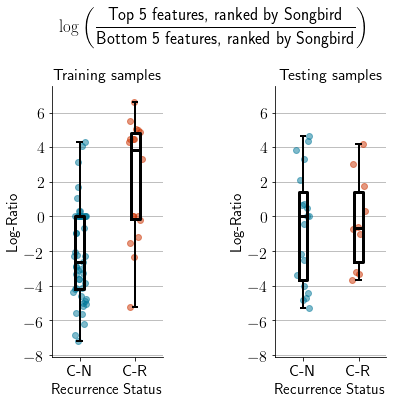

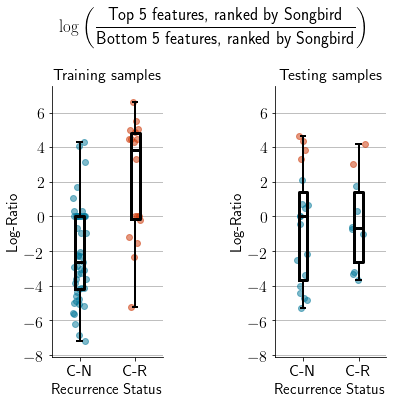

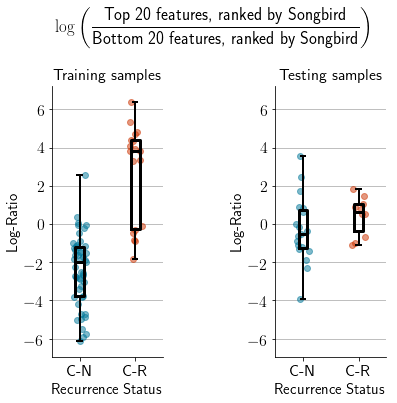

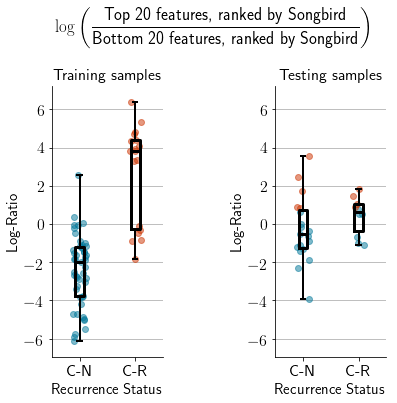

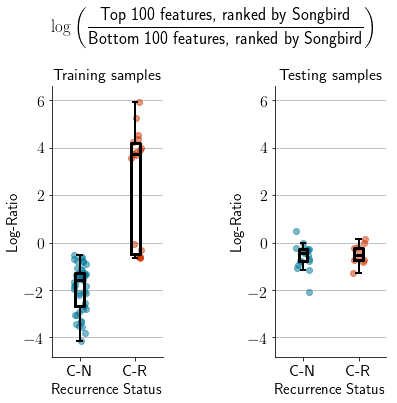

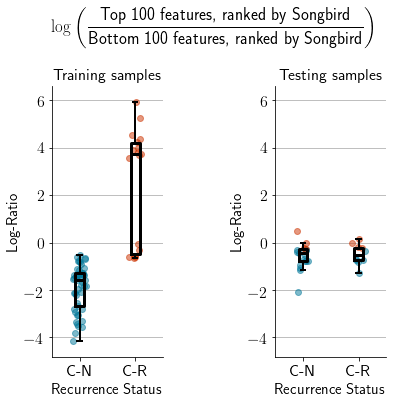

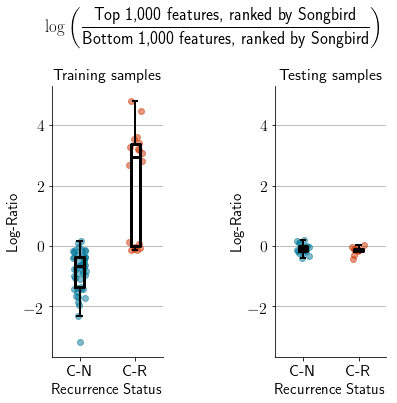

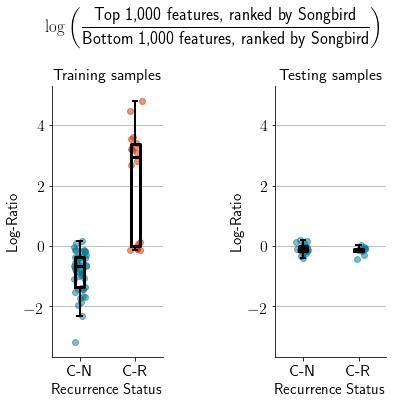

In [42]:
diffs_qza = Artifact.load("output/songbird-results/status-diffs.qza")
diffs = diffs_qza.view(pd.DataFrame)
status_diffs = diffs[diffs.columns[1]].sort_values()
for nv in NVALS:
    run_pipeline_n(status_diffs, nv, "Songbird")

## Evaluate limma results

Running pipeline for top/bottom 5 features.
Test ground truths: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test predictions:   [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]
True positives: 4
False positives: 6
True negatives: 13
False negatives: 6
Accuracy: 58.62%
Running pipeline for top/bottom 20 features.
Test ground truths: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test predictions:   [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
True positives: 2
False positives: 4
True negatives: 15
False negatives: 8
Accuracy: 58.62%
Running pipeline for top/bottom 100 features.
Test ground truths: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test predictions:   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
True positives: 0
False positives

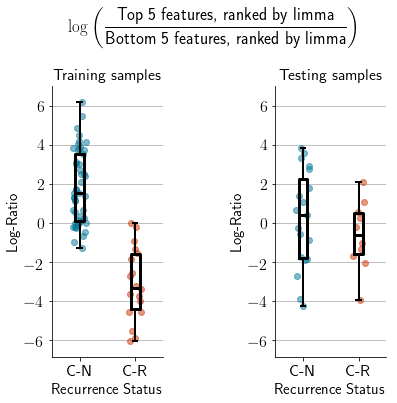

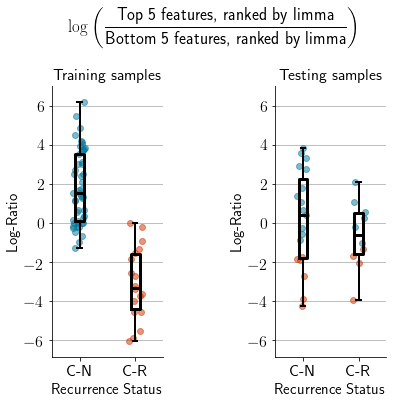

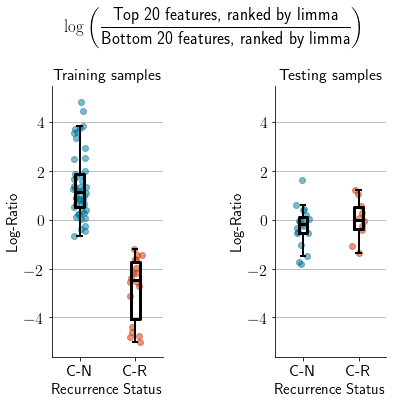

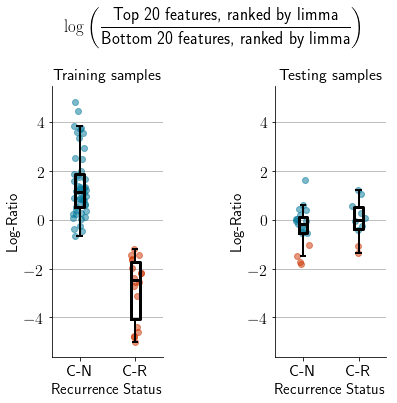

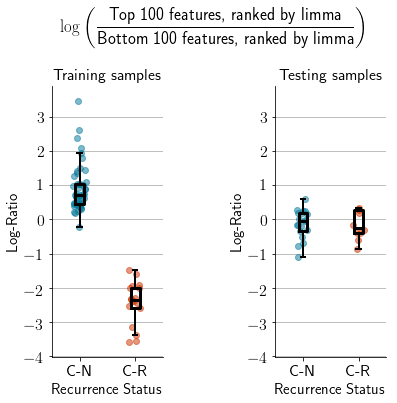

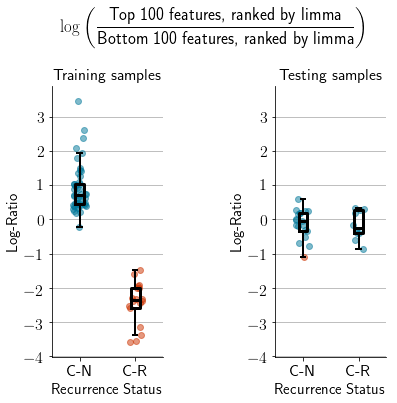

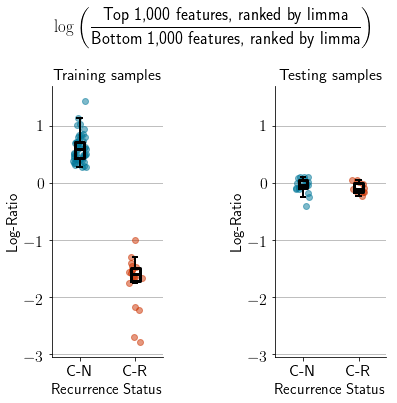

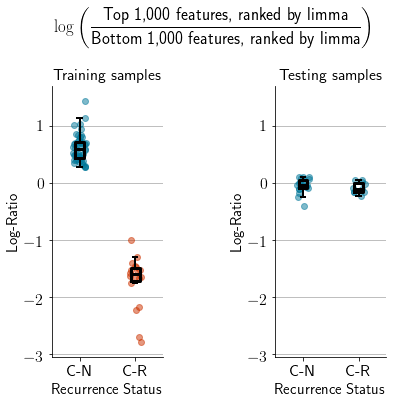

In [43]:
limma_fc = pd.read_csv("../data/limma_output.tsv", sep="\t", index_col=0)["logFC"].sort_values()
for nv in NVALS:
    run_pipeline_n(limma_fc, nv, "limma")

## Evaluate CoDaCore results: amalgamation

Test ground truths: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test predictions:   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True positives: 0
False positives: 0
True negatives: 19
False negatives: 10
Accuracy: 65.52%


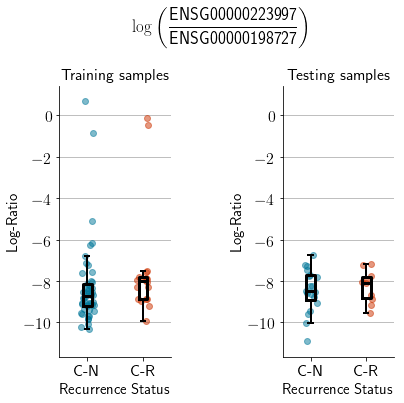

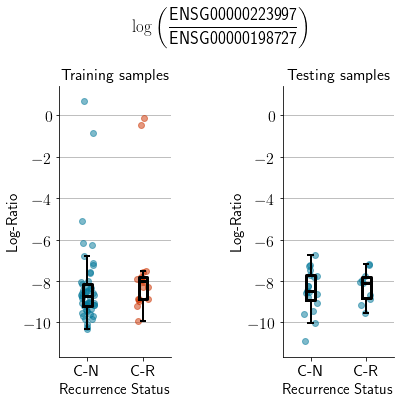

In [49]:
run_pipeline(
    ["ENSG00000223997"],
    ["ENSG00000198727"],
    "ENSG00000223997",
    "ENSG00000198727",
    fileprefix=f"codacore-amalgam",
    sharey=True
)

## Evaluate CoDaCore results: balances

Test ground truths: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test predictions:   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
True positives: 0
False positives: 5
True negatives: 14
False negatives: 10
Accuracy: 48.28%


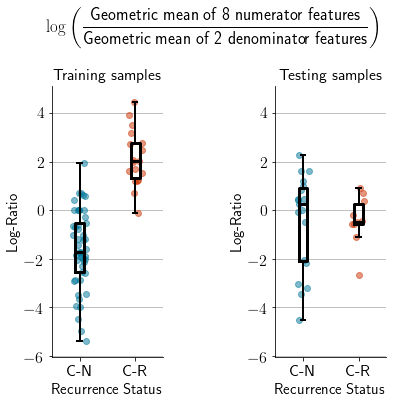

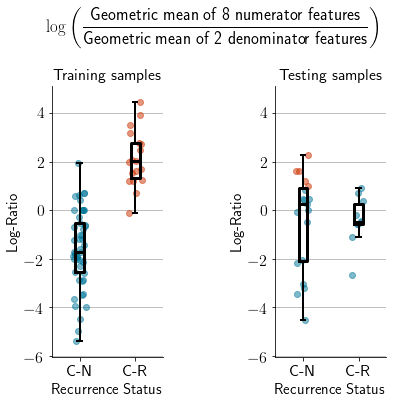

In [59]:
run_pipeline(
    ['ENSG00000199487', 'ENSG00000221446', 'ENSG00000222743',
     'ENSG00000229606', 'ENSG00000233286', 'ENSG00000239801',
     'ENSG00000258051', 'ENSG00000272795'],
    ['ENSG00000235293', 'ENSG00000251213'],
    "Geometric mean of 8 numerator features",
    "Geometric mean of 2 denominator features",
    compute_balances=True,
    fileprefix=f"codacore-balance0",
    sharey=True
)

Test ground truths: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test predictions:   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True positives: 0
False positives: 2
True negatives: 17
False negatives: 10
Accuracy: 58.62%


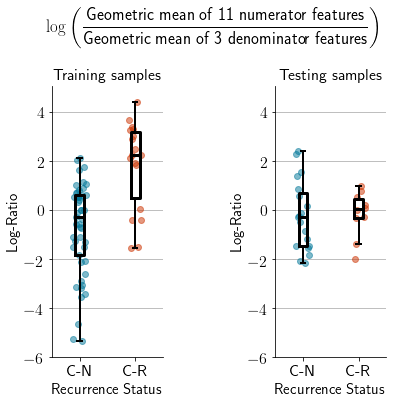

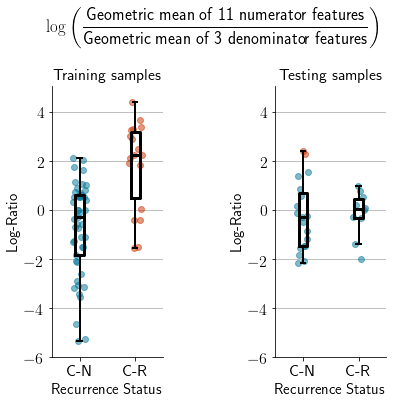

In [60]:
run_pipeline(
    ['ENSG00000201555', 'ENSG00000202538', 'ENSG00000207242',
       'ENSG00000229606', 'ENSG00000232963', 'ENSG00000235133',
       'ENSG00000236870', 'ENSG00000252015', 'ENSG00000253707',
       'ENSG00000258205', 'ENSG00000273478'],
    ['ENSG00000235526', 'ENSG00000242595', 'ENSG00000264125'],
    "Geometric mean of 11 numerator features",
    "Geometric mean of 3 denominator features",
    compute_balances=True,
    fileprefix=f"codacore-balance1",
    sharey=True
)

Test ground truths: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test predictions:   [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
True positives: 1
False positives: 3
True negatives: 16
False negatives: 9
Accuracy: 58.62%


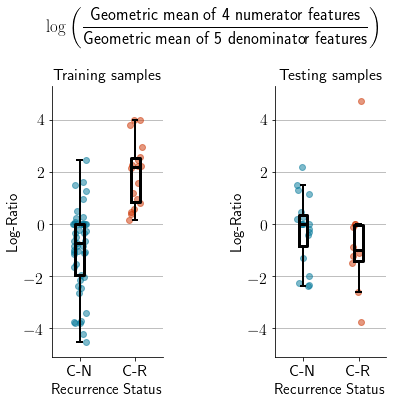

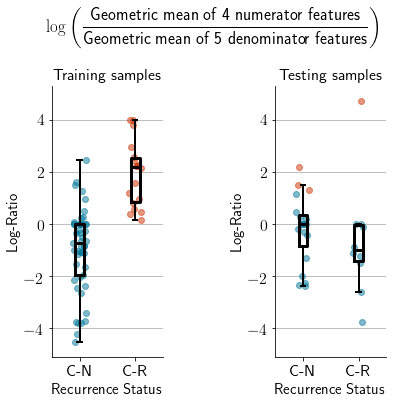

In [61]:
run_pipeline(
    ['ENSG00000201608', 'ENSG00000207242', 'ENSG00000207330',
       'ENSG00000239801'],
    ['ENSG00000199321', 'ENSG00000199362', 'ENSG00000203758',
       'ENSG00000212620', 'ENSG00000240960'],
    "Geometric mean of 4 numerator features",
    "Geometric mean of 5 denominator features",
    compute_balances=True,
    fileprefix=f"codacore-balance2",
    sharey=True
)

Test ground truths: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test predictions:   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
True positives: 1
False positives: 1
True negatives: 18
False negatives: 9
Accuracy: 65.52%


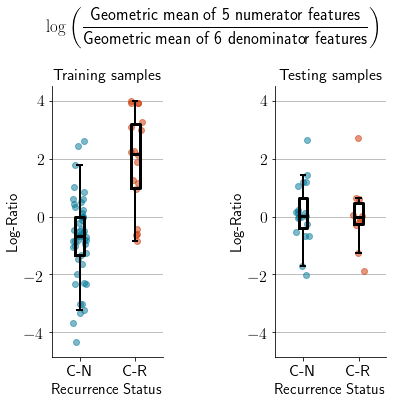

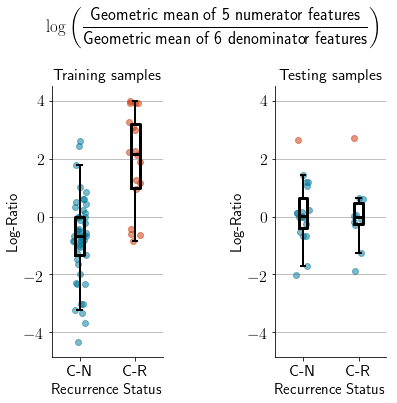

In [62]:
run_pipeline(
    ['ENSG00000199567', 'ENSG00000206734', 'ENSG00000221446',
       'ENSG00000261207', 'ENSG00000266258'],
    ['ENSG00000212620', 'ENSG00000235646', 'ENSG00000258836',
       'ENSG00000266052', 'ENSG00000275243', 'ENSG00000279239'],
    "Geometric mean of 5 numerator features",
    "Geometric mean of 6 denominator features",
    compute_balances=True,
    fileprefix=f"codacore-balance3",
    sharey=True
)

Test ground truths: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test predictions:   [0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
True positives: 3
False positives: 1
True negatives: 18
False negatives: 7
Accuracy: 72.41%


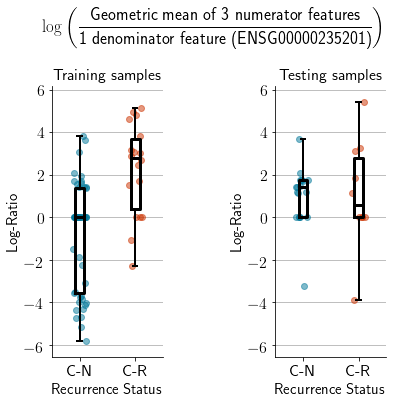

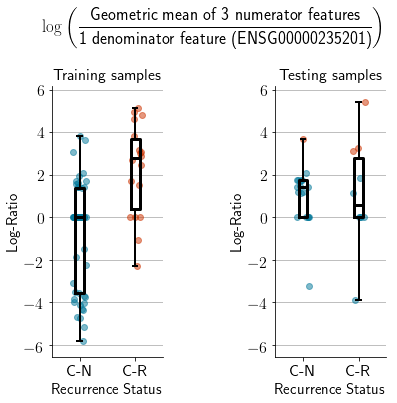

In [63]:
run_pipeline(
    ['ENSG00000221446', 'ENSG00000231985', 'ENSG00000233286'],
    ['ENSG00000235201'],
    "Geometric mean of 3 numerator features",
    "1 denominator feature (ENSG00000235201)",
    compute_balances=True,
    fileprefix=f"codacore-balance4",
    sharey=True
)